In [1]:
%pylab inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from pydoc import help
from scipy.stats.stats import pearsonr
from sklearn.metrics import explained_variance_score
from scipy.stats import wilcoxon
from sklearn.linear_model import Ridge
from sklearn.linear_model import LinearRegression
import warnings
warnings.filterwarnings('ignore')
from __future__ import print_function, division
plt.rcParams['figure.figsize'] = [7, 5]

Populating the interactive namespace from numpy and matplotlib


In [2]:
df=pd.read_csv('dil_field_val_results18-21.csv', header=0)
print (list(df))

['Unnamed: 0', 'Unnamed: 0.1', 'Unnamed: 0.1.1', 'uid', 'Site', 'obs_time', 'longitude', 'latitude', 'FPC', 'PPC', 'CC', 'PVg', 'NPVg', 'BGg', 'PV', 'NPV', 'BG', 'ba_trees', 'ba_shrubs', 'ba_total', 'imName', 'mean_1', 'std_1', 'median_1', 'Min_1', 'Max_1', 'count_1', 'mean_2', 'std_2', 'median_2', 'Min_2', 'Max_2', 'count_2', 'mean_3', 'std_3', 'median_3', 'Min_3', 'Max_3', 'count_3', 'mean_4', 'std_4', 'median_4', 'Min_4', 'Max_4', 'count_4']


In [3]:
shape(df.Site.unique())

(1100,)

In [4]:
df['sensor'] = df['imName'].map(lambda x: str(x)[0:2])
df['sensor'].unique()

array(['l8', 'l7'], dtype=object)

In [5]:
#df['field_date'] = df['obs_time'].map(lambda x: str(x)[-4:]) + '-' + df['obs_time'].map(lambda x: str(x)[-7:-5]) + '-' + df['obs_time'].map(lambda x: str(x)[0:2])

In [6]:
df['img_date'] =  df['imName'].map(lambda x: str(x)[-27:-23]) + '-' + df['imName'].map(lambda x: str(x)[-23:-21]) + '-' + df['imName'].map(lambda x: str(x)[-21:-19]) 

In [7]:
# apply the correction to the  

k = 6.56547773e-05
n = 2.21707912e+00


df['dil_pv'] = df['mean_2'] - 100
df['fpc_polyridge'] =  (0.01701615* df['dil_pv']) + (0.01056875*(np.power(df['dil_pv'],2))) + 3.6333343
df['dil_fpcC'] = 100*(1-(np.exp((-k*(np.power(df['dil_pv'],n))))))

In [8]:
# set up the field date and image date columns to find the number of days between the two dates

df['img_date'] = pd.to_datetime(df['img_date'], yearfirst=True, dayfirst=False) #format='%yyyy/%mm/%dd')
df.img_date.apply(pd.to_datetime)


df['obs_time'] = pd.to_datetime(df['obs_time'] , yearfirst=False, dayfirst=True,) # format='%d/%m/%y')

df['time_diff'] = df['img_date'] - df['obs_time']

In [9]:
# select out the imagery captured within five days of the field data capture
sel = df[(df['time_diff']<= "15 days") & (df['time_diff']>= "-15 days") & (df['count_2']>=9)] # & (df['sensor']== 'l7')]
s2 = sel[sel['Site'].notna()]
print (df.shape)
print (sel.shape)
print (s2.shape)

(5067, 51)
(3946, 51)
(3934, 51)


In [10]:
# select out record for each site that is closest to the field data and put it into a pandas dataframe to plot

new_imgList = [] 

for site in s2.Site.unique():
    
    s1 = s2[(s2['Site']== site)] 

    data =s1.loc[s1['time_diff'].idxmin()]
    
    new_imgList.append(data)
    
res = pd.DataFrame(new_imgList) 
print(res.shape)

(1094, 51)


In [11]:
print (list(res))

['Unnamed: 0', 'Unnamed: 0.1', 'Unnamed: 0.1.1', 'uid', 'Site', 'obs_time', 'longitude', 'latitude', 'FPC', 'PPC', 'CC', 'PVg', 'NPVg', 'BGg', 'PV', 'NPV', 'BG', 'ba_trees', 'ba_shrubs', 'ba_total', 'imName', 'mean_1', 'std_1', 'median_1', 'Min_1', 'Max_1', 'count_1', 'mean_2', 'std_2', 'median_2', 'Min_2', 'Max_2', 'count_2', 'mean_3', 'std_3', 'median_3', 'Min_3', 'Max_3', 'count_3', 'mean_4', 'std_4', 'median_4', 'Min_4', 'Max_4', 'count_4', 'sensor', 'img_date', 'dil_pv', 'fpc_polyridge', 'dil_fpcC', 'time_diff']


In [12]:
res.columns=['Unnamed: 0', 'Unnamed: 0.1', 'Unnamed: 0.1.1', 'uid', 'site', 'obs_time', 'longitude', 'latitude', 'fpc', 'PPC', 'CC', 'PVg', 'NPVg', 'BGg', 'PV', 'NPV', 'BG', 'ba_trees', 'ba_shrubs', 'ba_total', 'imName', 'mean_1', 'std_1', 'median_1', 'Min_1', 'Max_1', 'count_1', 'mean_2', 'std_2', 'median_2', 'Min_2', 'Max_2', 'count_2', 'mean_3', 'std_3', 'median_3', 'Min_3', 'Max_3', 'count_3', 'mean_4', 'std_4', 'median_4', 'Min_4', 'Max_4', 'count_4', 'sensor', 'img_date', 'dil_pv', 'fpc_polyridge', 'dil_fpcC', 'time_diff']

227.0
r2 = 0.43
0.48982873 -1.67964624
y =  -1.67964624+0.48982873*x
0.43 11.3 53.91 8.625 1094
mean = 4.99
std = 7.21
min =  0.0
max =  44.4


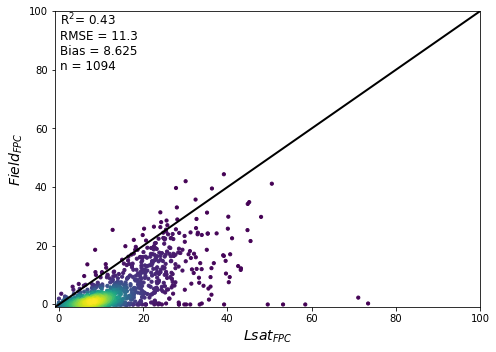

In [13]:
plt.rcParams['figure.figsize'] = [7, 5]
# selects the model using the spectral predictor variables 
x = res.dil_pv.values
y = res.fpc.values
res['res_L5'] =  res['dil_pv'] - res['fpc']
sumRes = res['res_L5'].sum()
"""
code to calculate the pearson's correlation coefficient and the coefficient of determination, 
the for loop extracts out the correlatin coeffiecent score which is a tuple containing the R and p value 
"""
r = pearsonr(x,y)
r2 = r[0:1]
personsr = []
for i in r:
    personsr.append(i)
r2 = personsr[0]**2
r2s = str(r2)

# calculates the variance 
meanN13error = res['res_L5'].mean()
n1 = len(res['dil_pv'])-1 
res['var1_l5'] = (res['res_L5']-meanN13error)**2
vari_n13 = str(res['var1_l5'].sum()/n1)

# formats the stats into strings to enable them to be put in as text in the plot
r2s = str(format(r2, '.2f'))
rmseS = str(format(np.sqrt(np.mean((y - x) ** 2)), '.1f'))
var_n13 = str(format(res['var1_l5'].sum()/n1,'.2f'))
biasS = str(format(sumRes /len(y), '.3f'))
nS = str(len(x))

# calculate the RMSE expressed as a percentage of the observed mean (RMSE%) for each response variable.

rRMSE = str(format((np.sqrt(np.mean((y - x) ** 2))/np.mean(y))*100,'.1f'))
print (rRMSE)

format(np.mean(x) - np.mean(y), '.1f')

# Calculate the point density for the scatter plot
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)

# Sort the points by density, so that the densest points are plotted last
idx = z.argsort()
x, y, z = x[idx], y[idx], z[idx]

# plots the data
fig, ax = plt.subplots()
ax1 = ax.scatter(x, y, c=z, s=10) # color='k', facecolors='none', edgecolors='k', edgecolor='')
#ax1 = ax.scatter(x, y,marker="o",facecolors='none',color='k',s=30,alpha=0.5,)
#fig.colorbar(ax1,ax=ax)


# data for the 1 for 1 line
a = [-1,110]
b = [-1,110]

#sets the limits of the axis
plt.xlim(-1,100)
plt.ylim(-1,100)

##########################################################################

X = res[['dil_pv']].values
ydata1 = res[["fpc"]].astype('float32')
Y = ydata1.values

ridgereg = Ridge(alpha=0.1,normalize=False,fit_intercept=True)
ridgereg.fit(X,Y)
y_pred = ridgereg.predict(X)

slope = str(ridgereg.coef_[:].round(8)).strip("[ ]")
intercept = str(ridgereg.intercept_[:].round(8)).strip("[ ]")
R2 = format((ridgereg.score(X,Y)),'.2')
print ('r2 =',(str(R2)))

print (slope, intercept)
print ("y = " , intercept +'+'+ slope + "*x")
intSlope = intercept +'+'+ slope + "x"


#ax.plot(a, b, color = 'black', linewidth=1)
#plt.plot(X, ridgereg.predict(X), linestyle="-", color='r',linewidth=1.5)
###########################################################################

# text for the x and y axis
plt.xlabel('$Lsat_{FPC}$',fontsize=14)
plt.ylabel('$Field_{FPC}$',fontsize=14)

# 25th percentile height

# text showing the results of the statistical analysis on the plot
plt.text(0.2,80, '$\mathregular{R^{2}}$= %s\nRMSE = %s\nBias = %s\nn = %s'%(r2s, rmseS,biasS, nS),fontsize=12)
print (r2s, rmseS, var_n13,biasS, nS)
#plt.title('FPC - RGB',fontsize=18)
# 1 for 1 line
ax.plot(a, b, color = 'black',linewidth=2)

plt.tight_layout()

# uncomment the save figure to save out the plot
print ('mean =', y.mean().round(2))
print ('std =', y.std().round(2))
print ('min = ', y.min().round(2))
print ('max = ', y.max().round(2))
#plt.savefig('PredObs_dc4_rgb.pdf',dpi=600)
plt.show()

227.0
mean = 4.99
std = 7.21
min =  0.0
max =  44.4


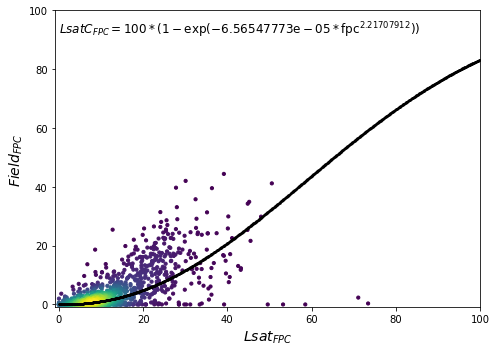

In [14]:
# selects the model using the spectral predictor variables 
x = res.dil_pv.values
y = res.fpc.values
res['res_L5'] =  res['dil_pv'] - res['fpc']
sumRes = res['res_L5'].sum()
"""
code to calculate the pearson's correlation coefficient and the coefficient of determination, 
the for loop extracts out the correlatin coeffiecent score which is a tuple containing the R and p value 
"""
r = pearsonr(x,y)
r2 = r[0:1]
personsr = []
for i in r:
    personsr.append(i)
r2 = personsr[0]**2
r2s = str(r2)

# calculates the variance 
meanN13error = res['res_L5'].mean()
n1 = len(res['dil_pv'])-1 
res['var1_l5'] = (res['res_L5']-meanN13error)**2
vari_n13 = str(res['var1_l5'].sum()/n1)

# formats the stats into strings to enable them to be put in as text in the plot
r2s = str(format(r2, '.2f'))
rmseS = str(format(np.sqrt(np.mean((y - x) ** 2)), '.1f'))
var_n13 = str(format(res['var1_l5'].sum()/n1,'.2f'))
biasS = str(format(sumRes /len(y), '.3f'))
nS = str(len(x))

# calculate the RMSE expressed as a percentage of the observed mean (RMSE%) for each response variable.

rRMSE = str(format((np.sqrt(np.mean((y - x) ** 2))/np.mean(y))*100,'.1f'))
print (rRMSE)

format(np.mean(x) - np.mean(y), '.1f')

# Calculate the point density for the scatter plot
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)

# Sort the points by density, so that the densest points are plotted last
idx = z.argsort()
x, y, z = x[idx], y[idx], z[idx]

# plots the data
fig, ax = plt.subplots()
ax1 = ax.scatter(x, y, c=z, s=10)
#ax1 = ax.scatter(x, y,marker="o",facecolors='none',color='k',s=30,alpha=0.5,)

# make up some data to get the best fit line
bestfit_data = np.arange(0,100,0.1)
bestfit_data
fit_line = 100*(1-(np.exp((-k*(np.power(bestfit_data,n)))))) 



ax.scatter(bestfit_data, fit_line,s=2,color='k')

#fig.colorbar(ax1,ax=ax)

# data for the 1 for 1 line
a = [-1,110]
b = [-1,110]

#sets the limits of the axis
plt.xlim(-1,100)
plt.ylim(-1,100)

# 1 for 1 line
#ax.plot(a, b, color = 'black',linewidth=2)

# text for the x and y axis
plt.xlabel('$Lsat_{FPC}$',fontsize=14)
plt.ylabel('$Field_{FPC}$',fontsize=14)


plt.tight_layout()
#plt.text(0, 85, '$\mathregular{R^{2}}$=0.88', fontsize=11)

plt.text(0, 92, '$LsatC_{FPC} = \mathregular{100*(1-exp(-6.56547773e-05*fpc^{2.21707912}))}$', fontsize=12)

# uncomment the save figure to save out the plot
print ('mean =', y.mean().round(2))
print ('std =', y.std().round(2))
print ('min = ', y.min().round(2))
print ('max = ', y.max().round(2))
#plt.savefig('fitted_line_dc4_fpc_AP_fpc.pdf',dpi=600)
plt.show()

126.4
r2 = 0.32
0.75494889 2.41105014
y =  2.41105014+0.75494889*x
0.32 6.3 37.30 -1.574 1094
mean = 4.99
std = 7.21
min =  0.0
max =  44.4


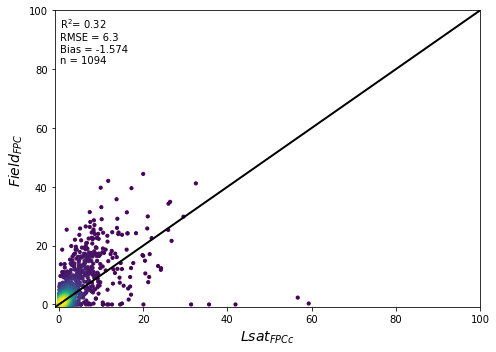

In [15]:
plt.rcParams['figure.figsize'] = [7, 5]
# selects the model using the spectral predictor variables 
x = res['dil_fpcC'].values
y = res.fpc.values
res['res_L5'] =  res['dil_fpcC'] - res['fpc']
sumRes = res['res_L5'].sum()
"""
code to calculate the pearson's correlation coefficient and the coefficient of determination, 
the for loop extracts out the correlatin coeffiecent score which is a tuple containing the R and p value 
"""
r = pearsonr(x,y)
r2 = r[0:1]
personsr = []
for i in r:
    personsr.append(i)
r2 = personsr[0]**2
r2s = str(r2)

# calculates the variance 
meanN13error = res['res_L5'].mean()
n1 = len(res['dil_fpcC'])-1 
res['var1_l5'] = (res['res_L5']-meanN13error)**2
vari_n13 = str(res['var1_l5'].sum()/n1)

# formats the stats into strings to enable them to be put in as text in the plot
r2s = str(format(r2, '.2f'))
rmseS = str(format(np.sqrt(np.mean((y - x) ** 2)), '.1f'))
var_n13 = str(format(res['var1_l5'].sum()/n1,'.2f'))
biasS = str(format(sumRes /len(y), '.3f'))
nS = str(len(x))

# calculate the RMSE expressed as a percentage of the observed mean (RMSE%) for each response variable.

rRMSE = str(format((np.sqrt(np.mean((y - x) ** 2))/np.mean(y))*100,'.1f'))
print (rRMSE)

format(np.mean(x) - np.mean(y), '.1f')

# Calculate the point density for the scatter plot
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)

# Sort the points by density, so that the densest points are plotted last
idx = z.argsort()
x, y, z = x[idx], y[idx], z[idx]

# plots the data
fig, ax = plt.subplots()
ax1 = ax.scatter(x, y, c=z, s=10) # color='k', facecolors='none', edgecolors='k', edgecolor='')
#ax1 = ax.scatter(x, y,marker="o",facecolors='none',color='k',s=30,alpha=0.5,)

# plt.scatter(x,diff, marker="o",linestyle = 'None',color='k',s=20,alpha=0.4)


# data for the 1 for 1 line
a = [-1,110]
b = [-1,110]

#sets the limits of the axis
plt.xlim(-1,100)
plt.ylim(-1,100)

##########################################################################
0.58
X = res[['dil_fpcC']].values
ydata1 = res[["fpc"]].astype('float32')
Y = ydata1.values

ridgereg = Ridge(alpha=0.1,normalize=False,fit_intercept=True)
ridgereg.fit(X,Y)
y_pred = ridgereg.predict(X)

slope = str(ridgereg.coef_[:].round(8)).strip("[ ]")
intercept = str(ridgereg.intercept_[:].round(8)).strip("[ ]")
R2 = format((ridgereg.score(X,Y)),'.2')
print ('r2 =',(str(R2)))

print (slope, intercept)
print ("y = " , intercept +'+'+ slope + "*x")
intSlope = intercept +'+'+ slope + "x"


#ax.plot(a, b, color = 'black', linewidth=1)
#plt.plot(X, ridgereg.predict(X), linestyle="-", color='r',linewidth=1)
###########################################################################

#plt.plot(res['dc4_fpc'].values, res['Boltzmann '].values, linestyle="-", color='r',linewidth=2)

# text for the x and y axis
plt.xlabel('$Lsat_{FPCc}$',fontsize=14)
plt.ylabel('$Field_{FPC}$',fontsize=14)

# 25th percentile height

# text showing the results of the statistical analysis on the plot
plt.text(0.2,82, '$\mathregular{R^{2}}$= %s\nRMSE = %s\nBias = %s\nn = %s'%(r2s, rmseS,biasS, nS),fontsize=10)
print (r2s, rmseS, var_n13,biasS, nS)
#plt.title('FPC - RGB',fontsize=18)
# 1 for 1 line
ax.plot(a, b, color = 'black',linewidth=2)

plt.tight_layout()

# uncomment the save figure to save out the plot
print ('mean =', y.mean().round(2))
print ('std =', y.std().round(2))
print ('min = ', y.min().round(2))
print ('max = ', y.max().round(2))
#plt.savefig('PredObs_training_dc4_FPCc_AP_FPC.pdf',dpi=600)
plt.show()

In [16]:
print (list(res))

['Unnamed: 0', 'Unnamed: 0.1', 'Unnamed: 0.1.1', 'uid', 'site', 'obs_time', 'longitude', 'latitude', 'fpc', 'PPC', 'CC', 'PVg', 'NPVg', 'BGg', 'PV', 'NPV', 'BG', 'ba_trees', 'ba_shrubs', 'ba_total', 'imName', 'mean_1', 'std_1', 'median_1', 'Min_1', 'Max_1', 'count_1', 'mean_2', 'std_2', 'median_2', 'Min_2', 'Max_2', 'count_2', 'mean_3', 'std_3', 'median_3', 'Min_3', 'Max_3', 'count_3', 'mean_4', 'std_4', 'median_4', 'Min_4', 'Max_4', 'count_4', 'sensor', 'img_date', 'dil_pv', 'fpc_polyridge', 'dil_fpcC', 'time_diff', 'res_L5', 'var1_l5']


31.1
r2 = 0.6
0.93627408 12.58440343
y =  12.58440343+0.93627408*x
0.60 18.3 247.57 -9.428 1094
mean = 58.96
std = 24.68
min =  1.67
max =  100.0


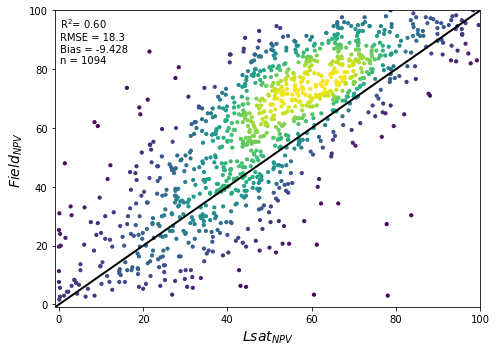

In [17]:
plt.rcParams['figure.figsize'] = [7, 5]
# selects the model using the spectral predictor variables 
x = res['mean_3'].values - 100
y = res.NPV.values
res['res_L5'] =  (res['mean_3']-100) - res['NPV']
sumRes = res['res_L5'].sum()
"""
code to calculate the pearson's correlation coefficient and the coefficient of determination, 
the for loop extracts out the correlatin coeffiecent score which is a tuple containing the R and p value 
"""
r = pearsonr(x,y)
r2 = r[0:1]
personsr = []
for i in r:
    personsr.append(i)
r2 = personsr[0]**2
r2s = str(r2)

# calculates the variance 
meanN13error = res['res_L5'].mean()
n1 = len(res['mean_3'])-1 
res['var1_l5'] = (res['res_L5']-meanN13error)**2
vari_n13 = str(res['var1_l5'].sum()/n1)

# formats the stats into strings to enable them to be put in as text in the plot
r2s = str(format(r2, '.2f'))
rmseS = str(format(np.sqrt(np.mean((y - x) ** 2)), '.1f'))
var_n13 = str(format(res['var1_l5'].sum()/n1,'.2f'))
biasS = str(format(sumRes /len(y), '.3f'))
nS = str(len(x))

# calculate the RMSE expressed as a percentage of the observed mean (RMSE%) for each response variable.

rRMSE = str(format((np.sqrt(np.mean((y - x) ** 2))/np.mean(y))*100,'.1f'))
print (rRMSE)

format(np.mean(x) - np.mean(y), '.1f')

# Calculate the point density for the scatter plot
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)

# Sort the points by density, so that the densest points are plotted last
idx = z.argsort()
x, y, z = x[idx], y[idx], z[idx]

# plots the data
fig, ax = plt.subplots()
ax1 = ax.scatter(x, y, c=z, s=10) # color='k', facecolors='none', edgecolors='k', edgecolor='')
#ax1 = ax.scatter(x, y,marker="o",facecolors='none',color='k',s=30,alpha=0.5,)

# plt.scatter(x,diff, marker="o",linestyle = 'None',color='k',s=20,alpha=0.4)


# data for the 1 for 1 line
a = [-1,110]
b = [-1,110]

#sets the limits of the axis
plt.xlim(-1,100)
plt.ylim(-1,100)

##########################################################################
0.58
X = res[['mean_3']].values - 100
ydata1 = res[["NPV"]].astype('float32')
Y = ydata1.values

ridgereg = Ridge(alpha=0.1,normalize=False,fit_intercept=True)
ridgereg.fit(X,Y)
y_pred = ridgereg.predict(X)

slope = str(ridgereg.coef_[:].round(8)).strip("[ ]")
intercept = str(ridgereg.intercept_[:].round(8)).strip("[ ]")
R2 = format((ridgereg.score(X,Y)),'.2')
print ('r2 =',(str(R2)))

print (slope, intercept)
print ("y = " , intercept +'+'+ slope + "*x")
intSlope = intercept +'+'+ slope + "x"


#ax.plot(a, b, color = 'black', linewidth=1)
#plt.plot(X, ridgereg.predict(X), linestyle="-", color='r',linewidth=1)
###########################################################################

#plt.plot(res['dc4_fpc'].values, res['Boltzmann '].values, linestyle="-", color='r',linewidth=2)

# text for the x and y axis
plt.xlabel('$Lsat_{NPV}$',fontsize=14)
plt.ylabel('$Field_{NPV}$',fontsize=14)

# 25th percentile height

# text showing the results of the statistical analysis on the plot
plt.text(0.2,82, '$\mathregular{R^{2}}$= %s\nRMSE = %s\nBias = %s\nn = %s'%(r2s, rmseS,biasS, nS),fontsize=10)
print (r2s, rmseS, var_n13,biasS, nS)
#plt.title('FPC - RGB',fontsize=18)
# 1 for 1 line
ax.plot(a, b, color = 'black',linewidth=2)

plt.tight_layout()

# uncomment the save figure to save out the plot
print ('mean =', y.mean().round(2))
print ('std =', y.std().round(2))
print ('min = ', y.min().round(2))
print ('max = ', y.max().round(2))
#plt.savefig('PredObs_training_dc4_FPCc_AP_FPC.pdf',dpi=600)
plt.show()

In [18]:
b_t = res

In [19]:
%pylab inline 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import seaborn as sns
import csv
import sklearn 
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import explained_variance_score
from sklearn import linear_model
from sklearn.metrics import r2_score
from scipy.stats.stats import pearsonr 

Populating the interactive namespace from numpy and matplotlib


In [20]:
print (list(b_t))

['Unnamed: 0', 'Unnamed: 0.1', 'Unnamed: 0.1.1', 'uid', 'site', 'obs_time', 'longitude', 'latitude', 'fpc', 'PPC', 'CC', 'PVg', 'NPVg', 'BGg', 'PV', 'NPV', 'BG', 'ba_trees', 'ba_shrubs', 'ba_total', 'imName', 'mean_1', 'std_1', 'median_1', 'Min_1', 'Max_1', 'count_1', 'mean_2', 'std_2', 'median_2', 'Min_2', 'Max_2', 'count_2', 'mean_3', 'std_3', 'median_3', 'Min_3', 'Max_3', 'count_3', 'mean_4', 'std_4', 'median_4', 'Min_4', 'Max_4', 'count_4', 'sensor', 'img_date', 'dil_pv', 'fpc_polyridge', 'dil_fpcC', 'time_diff', 'res_L5', 'var1_l5']


----------------------------------------------------------------
RMSE pv = 8.45
RMSE Bare = 15.37
RMSE npv = 18.34
n = 1094
----------------------------------------------------------------


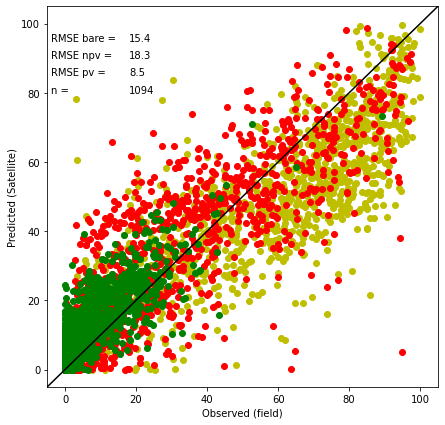

In [21]:
plt.rcParams['figure.figsize'] = [7, 7]
xb = b_t.mean_1.values - 100
yb = b_t.BG.values
xpv = b_t.mean_2.values - 100
ypv = b_t.PV.values 
xnpv = b_t.mean_3.values - 100
ynpv = b_t.NPV.values

plt.figure(1)

plt.scatter(ynpv, xnpv, color = 'y')
plt.scatter(yb, xb, color = 'r')
plt.scatter(ypv, xpv, color = 'g')
xlabel('Observed (field)')
ylabel('Predicted (Satellite)')
print ('----------------------------------------------------------------')
a = format(mean_squared_error(yb, xb)**0.5, '.1f')
b = format(mean_squared_error(ynpv, xnpv)**0.5, '.1f')
c = format(mean_squared_error(ypv, xpv)**0.5, '.1f')
d = len(yb)
print  ('RMSE pv =', format(mean_squared_error(ypv, xpv)**0.5, '.2f'))
print  ('RMSE Bare =', format(mean_squared_error(yb, xb)**0.5, '.2f'))
print  ('RMSE npv =', format(mean_squared_error(ynpv, xnpv)**0.5, '.2f'))
print  ('n =' , len(yb))
print ('----------------------------------------------------------------')
#data for the 1 for 1 line
x = [-5,105]
y = [-5,105]
#sets the limits of the axis
plt.xlim(-5, 105)
plt.ylim(-5, 105)
# 1 for 1 line
plt.plot(x, y, color = 'black')

#plt.suptitle(sensor, fontsize=14, fontweight='bold')
plt.text(-4, 95, 'RMSE bare =', ha='left', rotation=0)
plt.text(18, 95, a, ha='left', rotation=0)
plt.text(-4, 90, 'RMSE npv =', ha='left', rotation=0)
plt.text(18, 90, b, ha='left', rotation=0)
plt.text(-4, 85, 'RMSE pv =', ha='left', rotation=0)
plt.text(18, 85, c, ha='left', rotation=0)
plt.text(-4, 80, 'n =', ha='left', rotation=0)
plt.text(18, 80, d, ha='left', rotation=0)

fig = plt.figure(1)
#fig.savefig('FractionalCoverGroundMeasurments_10days_allsensors_NTsites.png', dpi=150)
plt.show()

----------------------------------------------------------------
RMSE pv = 13.66
RMSE Bare = 15.37
RMSE npv = 21.17
n = 1094
----------------------------------------------------------------


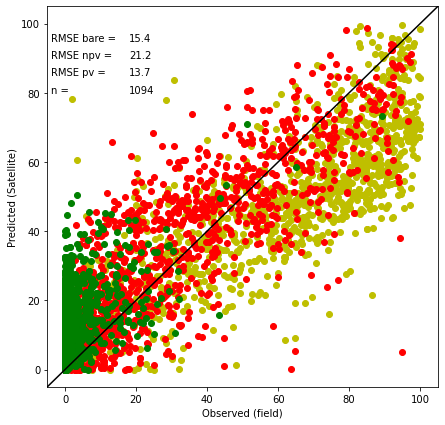

In [22]:
plt.rcParams['figure.figsize'] = [7, 7]
xb = b_t.mean_1.values - 100
yb = b_t.BGg.values
xpv = b_t.mean_2.values - 100
ypv = b_t.PVg.values 
xnpv = b_t.mean_3.values - 100
ynpv = b_t.NPVg.values

plt.figure(1)

plt.scatter(ynpv, xnpv, color = 'y')
plt.scatter(yb, xb, color = 'r')
plt.scatter(ypv, xpv, color = 'g')
xlabel('Observed (field)')
ylabel('Predicted (Satellite)')
print ('----------------------------------------------------------------')
a = format(mean_squared_error(yb, xb)**0.5, '.1f')
b = format(mean_squared_error(ynpv, xnpv)**0.5, '.1f')
c = format(mean_squared_error(ypv, xpv)**0.5, '.1f')
d = len(yb)
print  ('RMSE pv =', format(mean_squared_error(ypv, xpv)**0.5, '.2f'))
print  ('RMSE Bare =', format(mean_squared_error(yb, xb)**0.5, '.2f'))
print  ('RMSE npv =', format(mean_squared_error(ynpv, xnpv)**0.5, '.2f'))
print  ('n =' , len(yb))
print ('----------------------------------------------------------------')
#data for the 1 for 1 line
x = [-5,105]
y = [-5,105]
#sets the limits of the axis
plt.xlim(-5, 105)
plt.ylim(-5, 105)
# 1 for 1 line
plt.plot(x, y, color = 'black')

#plt.suptitle(sensor, fontsize=14, fontweight='bold')
plt.text(-4, 95, 'RMSE bare =', ha='left', rotation=0)
plt.text(18, 95, a, ha='left', rotation=0)
plt.text(-4, 90, 'RMSE npv =', ha='left', rotation=0)
plt.text(18, 90, b, ha='left', rotation=0)
plt.text(-4, 85, 'RMSE pv =', ha='left', rotation=0)
plt.text(18, 85, c, ha='left', rotation=0)
plt.text(-4, 80, 'n =', ha='left', rotation=0)
plt.text(18, 80, d, ha='left', rotation=0)

fig = plt.figure(1)
#fig.savefig('FractionalCoverGroundMeasurments_10days_allsensors_NTsites.png', dpi=150)
plt.show()